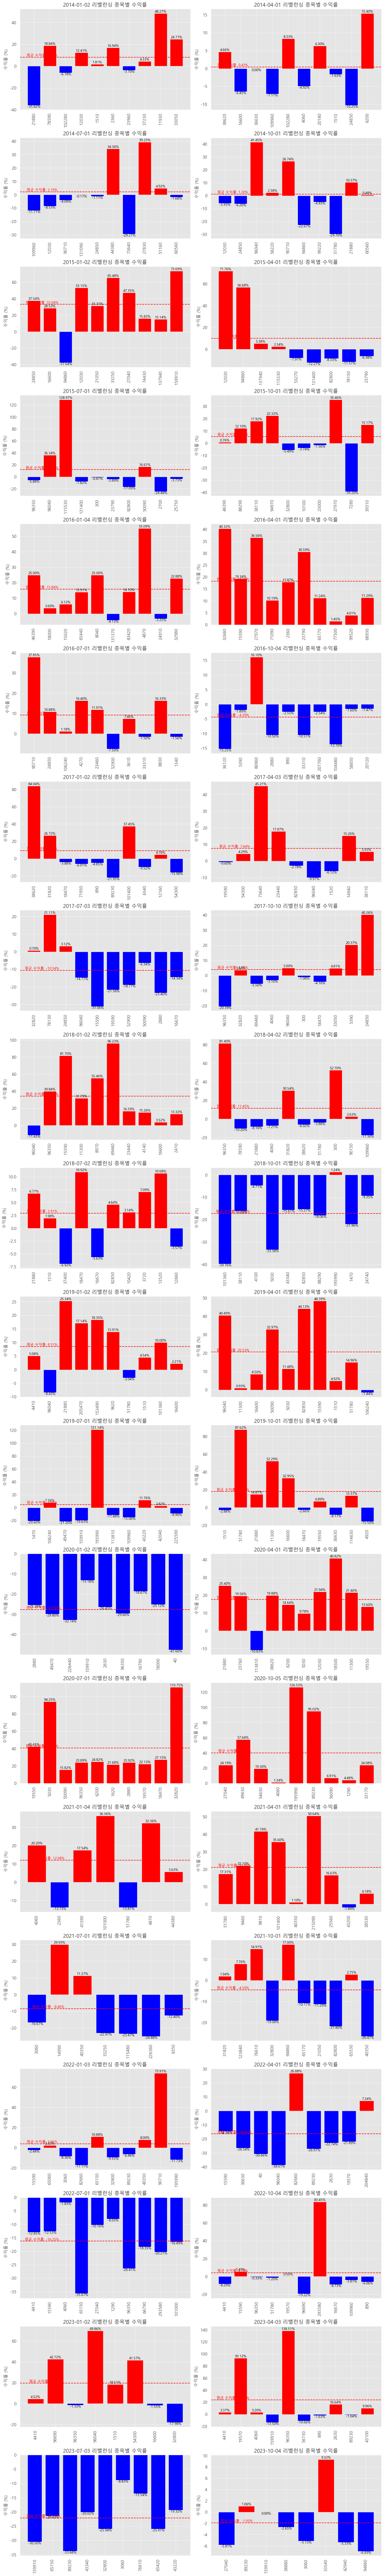

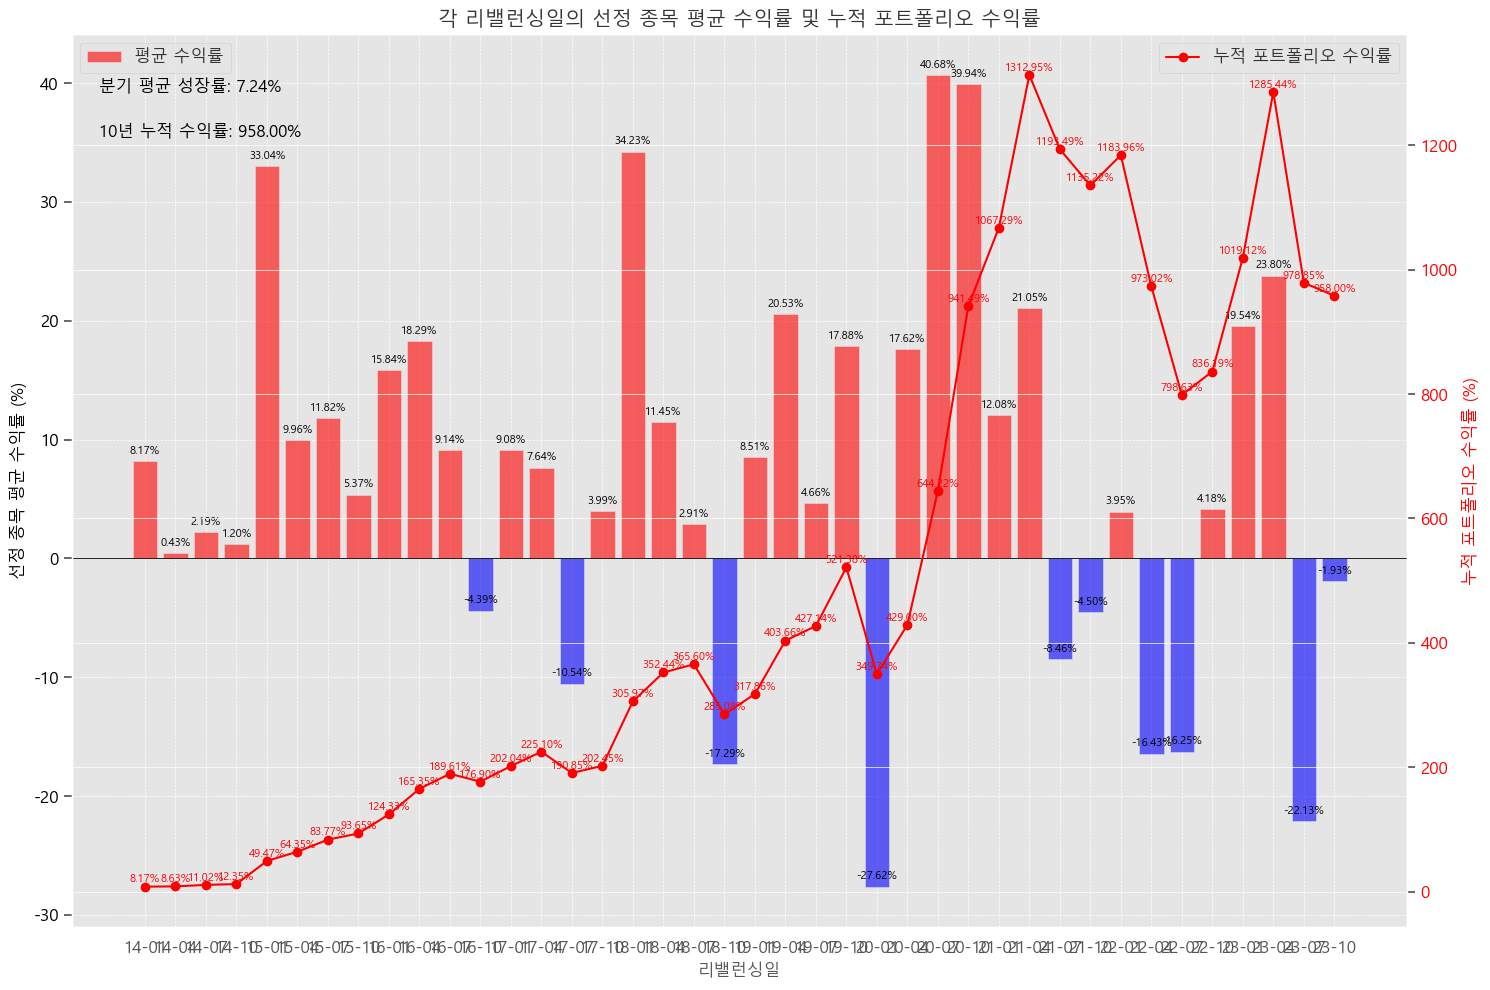

In [38]:
# Deep dive Strategy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict


# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 기본 전략을 사용하여 메인 함수 실행
if __name__ == "__main__":
    main(default_strategy)


In [51]:
close_df = pd.read_csv('reshape_df_1.0.csv')
close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', 
                '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                '2023-04-03', '2023-07-03', '2023-10-04']
# 주식 선택 실행
held_stocks, stock_returns, individual_stock_returns = select_stocks(default_strategy, close_df, rebalancing_dates)

# 각 재조정 날짜에 대해 선택된 주식을 출력해봅시다.
for date, stocks in held_stocks.items():
    print(f"{date}에 선택된 주식들: {stocks}")


2014-01-02에 선택된 주식들: ['21880', '78590', '102280', '12030', '1510', '2360', '23960', '37230', '11930', '33050']
2014-04-01에 선택된 주식들: ['38620', '16600', '36630', '109960', '102280', '4060', '20180', '1510', '24850', '6200']
2014-07-01에 선택된 주식들: ['109960', '12030', '90710', '131090', '24850', '44380', '73640', '27830', '51160', '60560']
2014-10-01에 선택된 주식들: ['12030', '24850', '96040', '58220', '90710', '94860', '99220', '51780', '21880', '60560']
2015-01-02에 선택된 주식들: ['24850', '16600', '94860', '12030', '21050', '33250', '27040', '74430', '137940', '159910']
2015-04-01에 선택된 주식들: ['12030', '94860', '137940', '115530', '53270', '131400', '82800', '11330', '78150', '23790']
2015-07-01에 선택된 주식들: ['96350', '96040', '115530', '131400', '300', '23790', '82800', '50090', '2700', '25750']
2015-10-01에 선택된 주식들: ['46390', '88290', '38110', '94970', '32800', '10100', '23000', '27970', '7280', '39310']
2016-01-04에 선택된 주식들: ['46390', '18000', '15020', '65440', '8040', '131370', '83420', '4870', '24910',

In [45]:
individual_stock_returns_dict

{'2014-01-02': {'021880': -35.82089552238806,
  '078590': 18.84057971014493,
  '102280': -6.181818181818182,
  '012030': 12.412177985948478,
  '001510': 1.809954751131222,
  '002360': 16.944444444444446,
  '023960': -3.6994219653179194,
  '037230': 4.329004329004329,
  '011930': 48.26589595375722,
  '033050': 24.766355140186917},
 '2014-04-01': {'038620': 4.6568627450980395,
  '016600': -6.451612903225806,
  '036630': 0.0,
  '109960': -7.112970711297072,
  '102280': 8.333333333333332,
  '004060': -4.923076923076923,
  '020180': 6.301824212271974,
  '001510': -1.6296296296296295,
  '024850': -10.25,
  '006200': 15.39528432732316},
 '2014-07-01': {'109960': -11.711711711711711,
  '012030': -8.527131782945736,
  '090710': -4.094827586206897,
  '131090': -0.16835016835016833,
  '024850': -1.1142061281337048,
  '044380': 34.36241610738255,
  '073640': -29.268292682926827,
  '027830': 39.23240938166311,
  '051160': 4.920212765957447,
  '060560': -1.683816651075772},
 '2014-10-01': {'012030':

In [46]:
close_df = pd.read_csv('reshape_df_1.0.csv')
close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', 
                '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                '2023-04-03', '2023-07-03', '2023-10-04']
# 날짜와 종목 코드만을 포함하는 리스트 생성
date_stock_list = [(date, stock_code) for date, returns in individual_stock_returns_dict.items() for stock_code in returns]

# 결과 출력
print(date_stock_list)

[('2014-01-02', '021880'), ('2014-01-02', '078590'), ('2014-01-02', '102280'), ('2014-01-02', '012030'), ('2014-01-02', '001510'), ('2014-01-02', '002360'), ('2014-01-02', '023960'), ('2014-01-02', '037230'), ('2014-01-02', '011930'), ('2014-01-02', '033050'), ('2014-04-01', '038620'), ('2014-04-01', '016600'), ('2014-04-01', '036630'), ('2014-04-01', '109960'), ('2014-04-01', '102280'), ('2014-04-01', '004060'), ('2014-04-01', '020180'), ('2014-04-01', '001510'), ('2014-04-01', '024850'), ('2014-04-01', '006200'), ('2014-07-01', '109960'), ('2014-07-01', '012030'), ('2014-07-01', '090710'), ('2014-07-01', '131090'), ('2014-07-01', '024850'), ('2014-07-01', '044380'), ('2014-07-01', '073640'), ('2014-07-01', '027830'), ('2014-07-01', '051160'), ('2014-07-01', '060560'), ('2014-10-01', '012030'), ('2014-10-01', '024850'), ('2014-10-01', '096040'), ('2014-10-01', '058220'), ('2014-10-01', '090710'), ('2014-10-01', '094860'), ('2014-10-01', '099220'), ('2014-10-01', '051780'), ('2014-10-0

In [44]:
held_stocks_dict

NameError: name 'held_stocks_dict' is not defined

In [43]:
stock_returns_dict

{'2014-01-02': 8.166627664509338,
 '2014-04-01': 0.4320014450797077,
 '2014-07-01': 2.194670154365229,
 '2014-10-01': 1.1991135674064866,
 '2015-01-02': 33.03605943271725,
 '2015-04-01': 9.961217913426456,
 '2015-07-01': 11.816282878977846,
 '2015-10-01': 5.374948394611222,
 '2016-01-04': 15.841772843176274,
 '2016-04-01': 18.285790369068078,
 '2016-07-01': 9.144226625720012,
 '2016-10-04': -4.3907010393154975,
 '2017-01-02': 9.079944302771361,
 '2017-04-03': 7.635416773540895,
 '2017-07-03': -10.535156967206298,
 '2017-10-10': 3.985928095853951,
 '2018-01-02': 34.227424316345875,
 '2018-04-02': 11.448126361174763,
 '2018-07-02': 2.909080048704673,
 '2018-10-01': -17.29414962112782,
 '2019-01-02': 8.511652590344188,
 '2019-04-01': 20.53408131510416,
 '2019-07-01': 4.66104277321885,
 '2019-10-01': 17.877881688645843,
 '2020-01-02': -27.622300802700984,
 '2020-04-01': 17.624982845283125,
 '2020-07-01': 40.68246271197557,
 '2020-10-05': 39.94402809955703,
 '2021-01-04': 12.078972669258755

In [42]:
held_stocks_dict

NameError: name 'held_stocks_dict' is not defined

In [41]:
def process_individual_stock_returns(individual_stock_returns_dict, rebalancing_dates, close_df):
    daily_returns_dict = {}

    for rebalance_date, stock_codes in individual_stock_returns_dict.items():
        # 종목 코드를 정수형 리스트로 변환합니다.
        stock_codes_int = {int(code): return_rate for code, return_rate in stock_codes.items()}

        # 다음 리밸런싱일을 찾습니다.
        rebalance_date_idx = rebalancing_dates.index(rebalance_date)
        if rebalance_date_idx + 1 < len(rebalancing_dates):
            end_date = rebalancing_dates[rebalance_date_idx + 1]
        else:
            end_date = close_df.index.max()

        # 일별 수익률을 계산합니다.
        daily_returns = calculate_daily_returns(close_df, list(stock_codes_int.keys()), rebalance_date, end_date)
        daily_returns_dict[rebalance_date] = daily_returns

    return daily_returns_dict

# 함수를 호출할 때 rebalancing_dates를 매개변수로 전달합니다.
daily_returns_dict = process_individual_stock_returns(individual_stock_returns_dict, rebalancing_dates, close_df)

NameError: name 'rebalancing_dates' is not defined

In [33]:
# CSV 파일에서 일별 종가 데이터 로드
close_df = pd.read_csv('reshape_df_1.0.csv', index_col='Date', parse_dates=True)

# 칼럼 이름의 형태 확인
print(close_df.columns.tolist())


['Unnamed: 0', '20', '40', '50', '70', '80', '100', '120', '140', '150', '180', '210', '220', '230', '240', '250', '270', '300', '320', '370', '390', '400', '430', '440', '480', '490', '500', '520', '540', '590', '640', '650', '660', '670', '680', '700', '720', '760', '810', '850', '860', '880', '890', '910', '950', '970', '990', '1000', '1020', '1040', '1060', '1070', '1080', '1120', '1130', '1140', '1200', '1210', '1230', '1250', '1260', '1270', '1290', '1340', '1360', '1380', '1390', '1420', '1430', '1440', '1450', '1460', '1470', '1500', '1510', '1520', '1530', '1540', '1550', '1560', '1570', '1620', '1630', '1680', '1720', '1740', '1750', '1770', '1780', '1790', '1800', '1810', '1820', '1840', '1880', '1940', '2020', '2030', '2070', '2100', '2140', '2150', '2170', '2200', '2210', '2220', '2230', '2240', '2290', '2310', '2320', '2350', '2360', '2380', '2390', '2410', '2420', '2450', '2460', '2600', '2620', '2630', '2680', '2700', '2710', '2720', '2760', '2780', '2790', '2810', '282

In [24]:
individual_stock_returns_dict

{'2014-01-02': 21880    -35.820896
 78590     18.840580
 102280    -6.181818
 12030     12.412178
 1510       1.809955
 2360      16.944444
 23960     -3.699422
 37230      4.329004
 11930     48.265896
 33050     24.766355
 dtype: float64,
 '2014-04-01': 38620      4.656863
 16600     -6.451613
 36630      0.000000
 109960    -7.112971
 102280     8.333333
 4060      -4.923077
 20180      6.301824
 1510      -1.629630
 24850    -10.250000
 6200      15.395284
 dtype: float64,
 '2014-07-01': 109960   -11.711712
 12030     -8.527132
 90710     -4.094828
 131090    -0.168350
 24850     -1.114206
 44380     34.362416
 73640    -29.268293
 27830     39.232409
 51160      4.920213
 60560     -1.683817
 dtype: float64,
 '2014-10-01': 12030    -5.932203
 24850    -6.197183
 96040    41.447368
 58220     2.384106
 90710    26.741573
 94860   -22.666667
 99220    -4.927536
 51780   -29.701953
 21880    10.367893
 60560     0.475737
 dtype: float64,
 '2015-01-02': 24850     37.537538
 16600     

In [25]:
# 각 종목 코드를 문자열로 변환하고 앞에 0을 붙여서 6자리로 만듭니다.
individual_stock_returns_dict = {
    date: returns.rename(index=lambda x: str(x).zfill(6))
    for date, returns in individual_stock_returns_dict.items()
}

In [26]:
individual_stock_returns_dict

{'2014-01-02': 021880   -35.820896
 078590    18.840580
 102280    -6.181818
 012030    12.412178
 001510     1.809955
 002360    16.944444
 023960    -3.699422
 037230     4.329004
 011930    48.265896
 033050    24.766355
 dtype: float64,
 '2014-04-01': 038620     4.656863
 016600    -6.451613
 036630     0.000000
 109960    -7.112971
 102280     8.333333
 004060    -4.923077
 020180     6.301824
 001510    -1.629630
 024850   -10.250000
 006200    15.395284
 dtype: float64,
 '2014-07-01': 109960   -11.711712
 012030    -8.527132
 090710    -4.094828
 131090    -0.168350
 024850    -1.114206
 044380    34.362416
 073640   -29.268293
 027830    39.232409
 051160     4.920213
 060560    -1.683817
 dtype: float64,
 '2014-10-01': 012030    -5.932203
 024850    -6.197183
 096040    41.447368
 058220     2.384106
 090710    26.741573
 094860   -22.666667
 099220    -4.927536
 051780   -29.701953
 021880    10.367893
 060560     0.475737
 dtype: float64,
 '2015-01-02': 024850    37.537538
 

In [30]:
import pandas as pd

# CSV 파일에서 일별 종가 데이터 로드
close_df = pd.read_csv('reshape_df_1.0.csv', index_col='Date', parse_dates=True)

# # 종목 코드를 문자열로 변환하고 필요한 경우 앞에 0을 추가하여 6자리로 만듭니다.
# individual_stock_returns_dict = {date: {f"{int(stock_code):06}": ret for stock_code, ret in returns.items()} 
#                                  for date, returns in individual_stock_returns_dict.items()}

# 일별 수익률을 계산하는 함수
def calculate_daily_returns(close_df, stock_codes, start_date, end_date):
    # 해당 기간의 종가 데이터를 필터링합니다.
    period_close_prices = close_df[stock_codes].loc[start_date:end_date]
    
    # 일별 수익률을 계산합니다.
    daily_returns = period_close_prices.pct_change().fillna(0)
    
    return daily_returns

# 각 리밸런싱 기간에 대해 일별 수익률을 계산합니다.
daily_returns_dict = {}
for rebalance_date, stock_codes in individual_stock_returns_dict.items():
    start_date = pd.to_datetime(rebalance_date)
    if rebalance_date in individual_stock_returns_dict:
        end_date = pd.to_datetime(list(individual_stock_returns_dict.keys())[list(individual_stock_returns_dict.keys()).index(rebalance_date)+1]) - pd.Timedelta(days=1)
    else:
        end_date = close_df.index.max()  # 마지막 리밸런싱일 경우 데이터의 마지막 날짜를 사용
    daily_returns = calculate_daily_returns(close_df, list(stock_codes.keys()), start_date, end_date)
    daily_returns_dict[rebalance_date] = daily_returns


KeyError: "['021880', '078590', '012030', '001510', '002360', '023960', '037230', '011930', '033050'] not in index"

In [28]:
data = pd.read_csv('reshape_df_1.0.csv')
data.head()


,Unnamed: 0,Date,20,40,50,70,80,100,120,140,...,439090,440320,453340,454910,456040,457190,460850,460860,443250,451220
0,0,2012-10-25,6340.0,3445.0,7678.0,75000.0,28950.0,26369.0,111500.0,13900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2012-10-26,6200.0,3451.0,7678.0,72800.0,29200.0,25856.0,111000.0,13400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012-10-29,6270.0,3366.0,7602.0,71900.0,30350.0,25560.0,114000.0,13650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2012-10-30,6390.0,3366.0,7602.0,69900.0,30950.0,26444.0,115000.0,13700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-10-31,6500.0,3372.0,7716.0,71500.0,32250.0,27770.0,113500.0,14000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def main(strategy_function):
    global stock_returns_dict, individual_stock_returns_dict  # 전역 변수로 선언
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']
    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화 (이 함수 호출은 주석 처리하거나 제거할 수 있습니다)
    # visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 포트폴리오 성과 시각화 (이 함수 호출은 주석 처리하거나 제거할 수 있습니다)
    # visualize_portfolio_performance(stock_returns_dict)


C:\Users\USER\AppData\Local\Temp\ipykernel_19840\1592444230.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_returns_daily = portfolio_returns.asfreq('B').fillna(method='ffill')


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pa

                           Strategy
-------------------------  -----------------------------------------------------------------------------------------------
Start Period               2014-01-02
End Period                 2023-10-04
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          256,479,569,514,667,854,308,338,483,749,467,239,229,336,414,944,369,364,133,626,677,035,008.00%
CAGR﹪                     4991342.59%

Sharpe                     7.42
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.6
Sortino                    15.17
Smart Sortino              1.23
Sortino/√2                 10.73
Smart Sortino/√2           0.87
Omega                      3.22

Max Drawdown               -100.0%
Longest DD Days            826
Volatility (ann.)          250.75%
Calmar                     49913.43
Skew                       -0.01
Kurtosis                   -0.1

Expected Daily %           6.19%
Expected Monthly %         265.42%
Expec

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-07-01,2022-10-03,2023-10-04,826,-100.000000,-100.000000
2,2020-01-02,2020-03-31,2020-08-10,222,-100.000000,-100.000000
3,2018-10-01,2019-01-01,2019-05-24,236,-99.999702,-99.999649
4,2017-07-03,2017-10-09,2018-01-25,207,-99.963075,-99.960073
5,2016-10-04,2016-12-30,2017-02-15,135,-94.350519,-94.091076


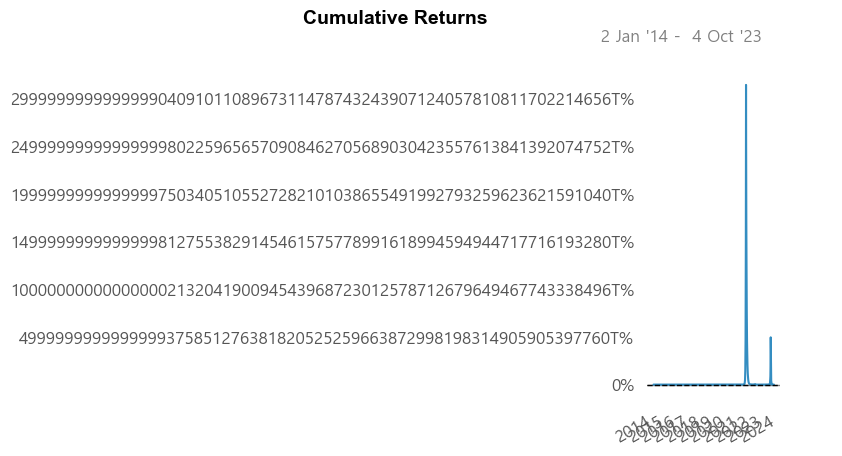

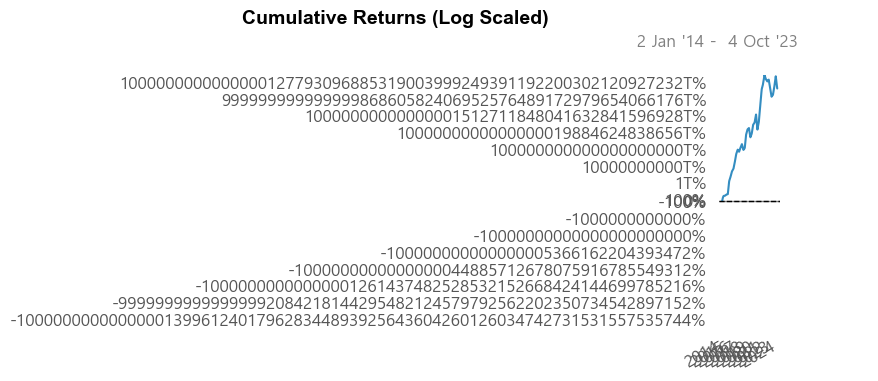

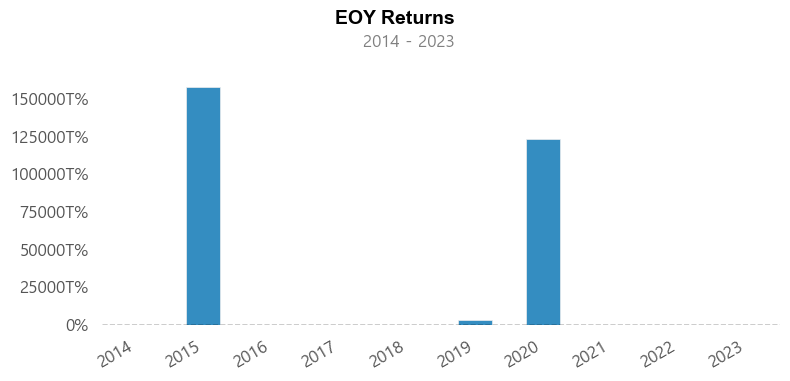

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

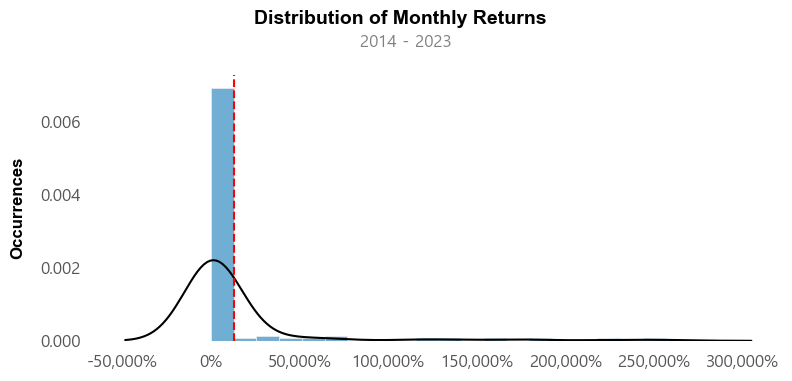

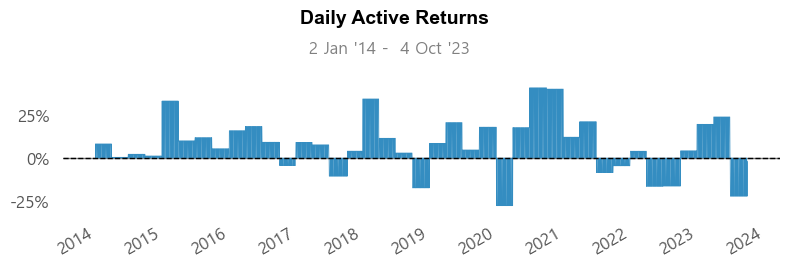

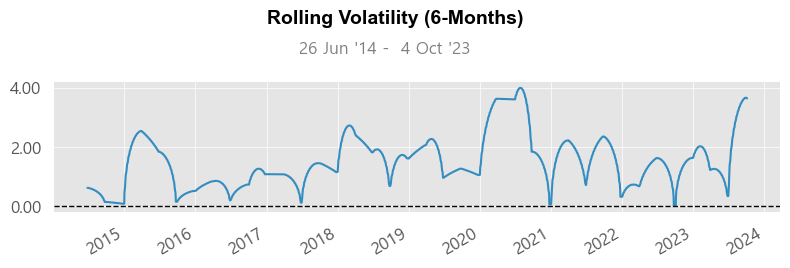

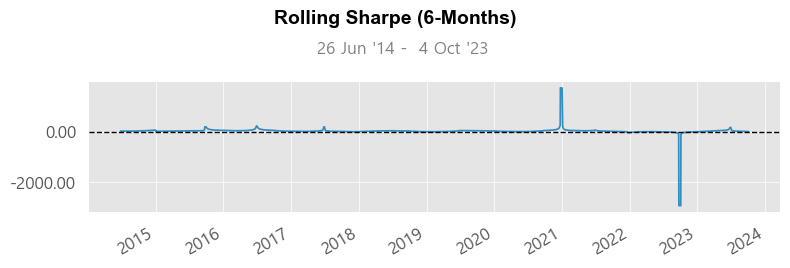

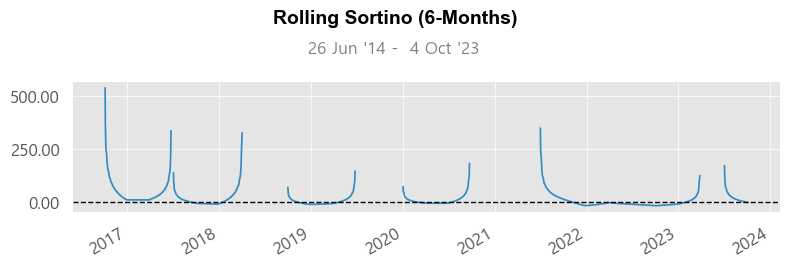

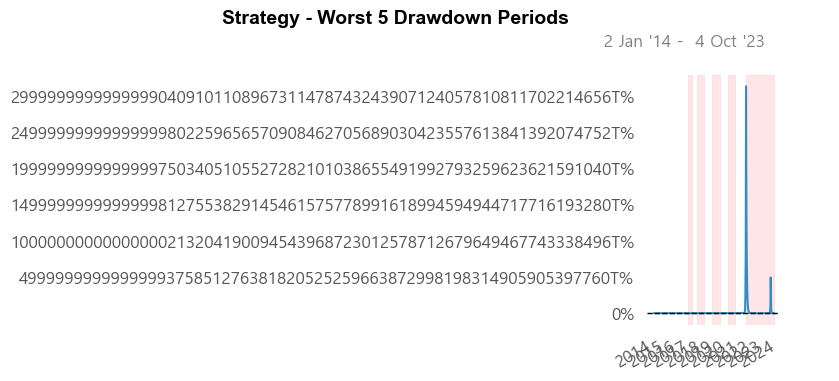

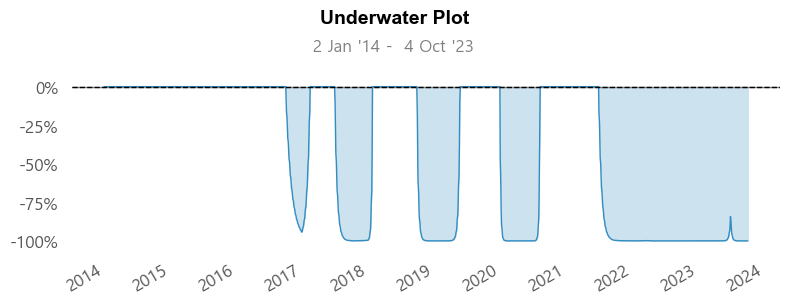

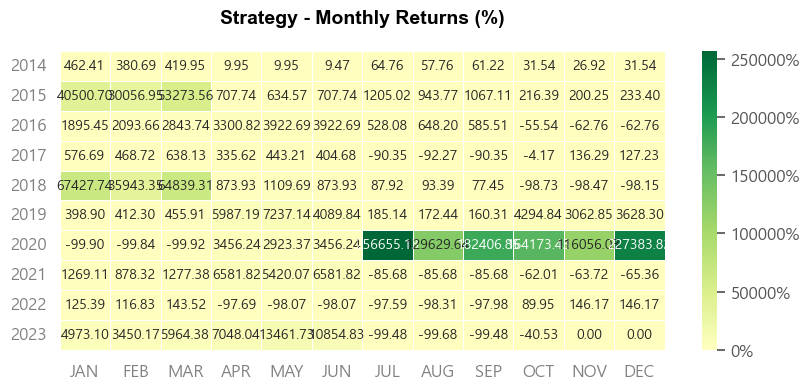

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

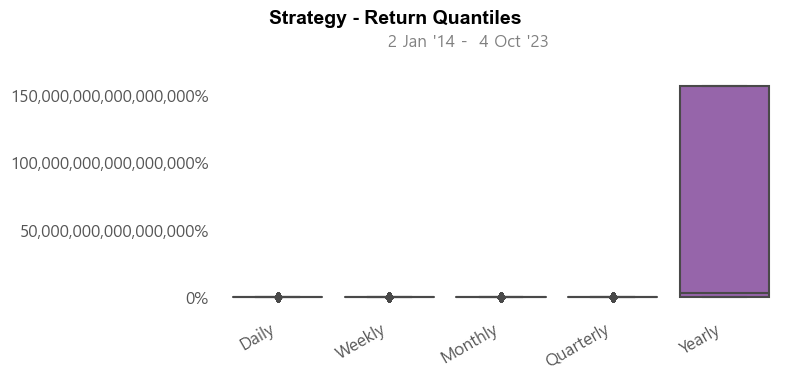

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\quantstats\_plotting\wrappers.py:246: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.tight_layout(w_pad=0, h_pad=0)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\quantstats\_plotting\wrappers.py:246: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.tight_layout(w_pad=0, h_pad=0)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\quantstats\_plotting\wrappers.py:246: UserWarning: Glyph 54260 (\N{HANGUL SYLLABLE POL}) missing from current font.
  fig.tight_layout(w_pad=0, h_pad=0)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\quantstats\_plotting\wrappers.py:246: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.tight_layout(w_pad=0, h_pad=0)
C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\quantstats\_plotting\wrappers.py:246: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) mis

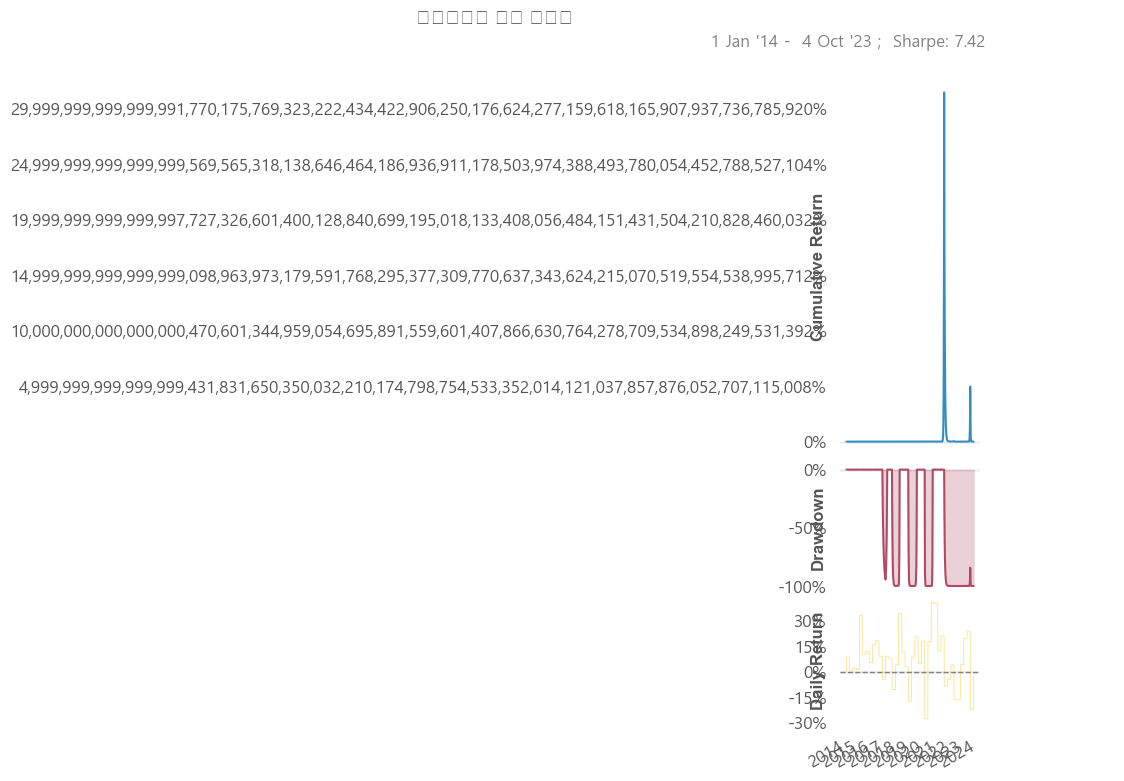

C:\Users\USER\AppData\Local\Temp\ipykernel_19840\1592444230.py:205: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_returns_daily.index = pd.to_datetime(stock_returns_daily.index)


DateParseError: year 21880 is out of range: 21880, at position 0

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import quantstats as qs  # QuantStats 라이브러리 추가

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict


# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 결과 반환
    return stock_returns_dict, individual_stock_returns_dict

# main 함수를 실행하여 필요한 데이터를 가져옵니다.
stock_returns_dict, individual_stock_returns_dict = main(default_strategy)

# 포트폴리오 수익률을 일별 데이터로 변환합니다.
# 리밸런싱일을 기준으로 포트폴리오 수익률을 계산합니다.
portfolio_returns = pd.Series(stock_returns_dict).fillna(0) / 100
portfolio_returns.index = pd.to_datetime(portfolio_returns.index)
# 모든 영업일로 데이터를 리샘플링합니다.
portfolio_returns_daily = portfolio_returns.asfreq('B').fillna(method='ffill')

# 전체 포트폴리오 수익률에 대한 QuantStats 분석 및 시각화를 실행합니다.
qs.reports.full(portfolio_returns_daily)
qs.plots.snapshot(portfolio_returns_daily, title='포트폴리오 일별 수익률')

# 개별 종목 수익률에 대한 QuantStats 분석 및 시각화를 실행합니다.
for date, individual_returns in individual_stock_returns_dict.items():
    # 일별 수익률로 변환합니다.
    stock_returns_daily = pd.Series(individual_returns).fillna(0) / 100
    stock_returns_daily.index = pd.to_datetime(stock_returns_daily.index)
    # 모든 영업일로 데이터를 리샘플링합니다.
    stock_returns_daily = stock_returns_daily.asfreq('B').fillna(method='ffill')

    print(f'{date} 리밸런싱 종목별 QuantStats 분석:')
    qs.reports.full(stock_returns_daily)
    qs.plots.snapshot(stock_returns_daily, title=f'{date} 리밸런싱 종목별 일별 수익률')

# HTML 보고서를 생성하고 싶은 경우, QuantStats의 html_report 함수를 사용할 수 있습니다.
# 예시:
qs.reports.html(stock_returns_daily, output='report.html')


In [ ]:
# # Deep dive Strategy

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FixedLocator

# # 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
# def select_stocks(strategy_function, close_df, rebalancing_dates):
#     close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
#     held_stocks_dict = {}
#     stock_returns_dict = {}
#     individual_stock_returns_dict = {}
    
#     for idx, date in enumerate(rebalancing_dates):
#         # 해당 기간의 데이터 추출
#         start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
#         period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
#         # 전략 함수를 사용하여 종목 선정
#         selected_stocks = strategy_function(period_df)
        
#         # 선정된 종목 저장
#         held_stocks_dict[date] = selected_stocks
        
#         # 선정된 종목의 다음 기간 수익률 계산
#         if idx + 1 < len(rebalancing_dates):
#             next_date = pd.to_datetime(rebalancing_dates[idx + 1])
#         else:
#             next_date = close_df['Date'].max()
        
#         next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
#         returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
#         # 종목별 수익률 저장
#         stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
#         individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
#     return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict


# def momentum_strategy(close_df, rebalance_date, lookback_period=3):
#     # rebalance_date로부터 lookback_period만큼 이전 날짜를 계산
#     start_date = pd.to_datetime(rebalance_date) - pd.DateOffset(months=lookback_period)
#     period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(rebalance_date))].drop(columns='Date')
    
#     # 가격 상승률 계산
#     price_change = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    
#     # 상승률이 높은 종목 10개 선정
#     selected_stocks = price_change.nlargest(10).index.tolist()
    
#     return selected_stocks


# # 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
# def visualize_individual_stock_returns(individual_stock_returns_dict):
#     plt.rcParams['font.family'] = 'Malgun Gothic'
#     plt.rcParams['axes.unicode_minus'] = False
#     plt.style.use('ggplot')  # 그래프 스타일 설정
    
#     num_plots = len(individual_stock_returns_dict)
#     num_columns = 2
#     num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

#     fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
#     axs = axs.flatten()
    
#     for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
#         # NaN 값이 있을 경우 제외하고 평균을 계산
#         valid_returns = returns.dropna()
#         if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
#             continue

#         stocks = valid_returns.index
#         performance = valid_returns.values
#         colors = ['red' if r > 0 else 'blue' for r in performance]
#         ax.bar(stocks, performance, color=colors)
#         ax.set_title(f'{date} 리밸런싱 종목별 수익률')

#         ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
#         ax.set_xticklabels(stocks, rotation=90)
#         ax.set_ylabel('수익률 (%)')
        
#         # 유효한 수익률만을 사용하여 평균 계산
#         average_return = valid_returns.mean()
#         ax.axhline(average_return, color='red', linestyle='--')
#         if pd.notna(average_return):
#             ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='blue', ha='center', va='bottom')

#         # 유효한 위치 값만을 사용하여 텍스트 추가
#         for i, v in enumerate(performance):
#             if pd.notna(v):
#                 ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

#     plt.tight_layout()
#     plt.show()

# # 포트폴리오 성과를 시각화하는 함수
# def visualize_portfolio_performance(portfolio_returns):
#     plt.rcParams['font.family'] = 'Malgun Gothic'
#     plt.rcParams['axes.unicode_minus'] = False

#     # 누적 포트폴리오 수익률 계산
#     cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

#     # 분기 평균 성장률과 누적 수익률 계산
#     quarterly_average_growth = np.mean(list(portfolio_returns.values()))
#     total_cumulative_return = cumulative_portfolio_returns[-1]

#     # 그래프 생성
#     fig, ax1 = plt.subplots(figsize=(15, 10))

#     # 날짜 형식 변환
#     formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

#     # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
#     colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
#     bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
#     ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
#     ax1.set_xlabel('리밸런싱일')
#     ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
#     ax1.tick_params(axis='y', labelcolor='black')
#     ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax1.axhline(0, color='black', linewidth=0.6)

#     # 막대 위에 수치 표시
#     for bar, value in zip(bars, portfolio_returns.values()):
#         height = bar.get_height()
#         ax1.annotate(f'{value:.2f}%',
#                      xy=(bar.get_x() + bar.get_width() / 2, height),
#                      xytext=(0, 3),  # 3 points vertical offset
#                      textcoords="offset points",
#                      ha='center', va='bottom', fontsize=8, color='black')

#     # 포트폴리오의 누적 수익률 선그래프로 그리기
#     ax2 = ax1.twinx()
#     lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
#     ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
#     ax2.tick_params(axis='y', labelcolor='red')

#     # 선 위에 수치 표시
#     for i, txt in enumerate(cumulative_portfolio_returns):
#         ax2.annotate(f'{txt:.2f}%', 
#                      (formatted_dates[i], cumulative_portfolio_returns[i]), 
#                      textcoords="offset points", 
#                      xytext=(0,3), 
#                      ha='center', fontsize=8, color='red')

#     # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
#     ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
#     ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

#     # 범례 표시
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     # 그래프 레이아웃 조정 및 표시
#     plt.tight_layout()
#     plt.show()


# # 메인 함수: 전략을 적용하고 결과를 시각화
# def main(strategy_function):
#     # 데이터 로드 (실제 경로로 수정 필요)
#     close_df = pd.read_csv('reshape_df_1.0.csv')
#     close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

#     # 리밸런싱일 정의하기
#     rebalancing_dates = ['2014-01-02', 
#                     '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
#                     '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
#                     '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
#                     '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
#                     '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
#                     '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
#                     '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
#                     '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
#                     '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
#                     '2023-04-03', '2023-07-03', '2023-10-04']

#     # 종목 선정 및 수익률 계산
#     held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

#     # 개별 종목 수익률 시각화
#     visualize_individual_stock_returns(individual_stock_returns_dict)
    
#     # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
#     portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

#     # 결과 시각화
#     visualize_portfolio_performance(portfolio_returns)

# # 기본 전략을 사용하여 메인 함수 실행
# if __name__ == "__main__":
#     main(default_strategy)
